In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model
from datetime import datetime
import seaborn as sns

from funciones_OD import *

#from sklearn.metrics import mean_squared_error
#from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import RobustScaler
#import keras as keras
#from keras.models import Sequential
#from keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed
#import tensorflow as tf


#pd.options.mode.chained_assignment = None  # default='warn' --- Para quitar los warnings de pandas y python
#tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) # Quitar warnings tensorflow

ruta = "F:/PhD/Datos SIATA/Análisis/Descriptivo/"
archivo = "DF"
sensor = "pm25"
redondeo = 4
datos = pd.read_csv(ruta+"test_"+archivo+"_outliers_N.csv",sep=",")
entreno = pd.read_csv(ruta+"nodos_entrenamiento_sin_outliers_"+archivo+".csv",sep=",")
variables = ['pm25']#,'humedad_relativa', 'temperatura'
for sensor in variables:
    datos[sensor] = pd.Series([round(val,redondeo) for val in datos[sensor]])
    entreno[sensor] = pd.Series([round(val,redondeo) for val in entreno[sensor]])

print("cantidad de datos de test: ", len(datos))

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


cantidad de datos de test:  38537


In [2]:
nodo_entreno = [50, 134, 187, 266]
entrenamiento = pd.DataFrame()
prediccion = pd.DataFrame()
variable = sensor
parte_entreno = 0.7

inicio = datetime.now()
#now = datetime.now()
#time_rnn = datetime(now.year, now.month, now.day, 00, 00, 00, 00000)

for en in nodo_entreno:
    datos_entreno = entreno.loc[entreno.loc[:,"codigoSerial"] == en]
    #datos_entreno = datos_entreno.iloc[:round(len(datos_entreno)*0.1),:]
    cant_entreno = round(len(datos_entreno)*parte_entreno)
    entrenamiento = pd.concat([entrenamiento,datos_entreno.iloc[:cant_entreno,:]],ignore_index=True)
    prediccion = pd.concat([prediccion,datos_entreno.iloc[cant_entreno:,:]],ignore_index=True)


entrenamiento["fechaHora"] = entrenamiento["fecha"] + " " + entrenamiento["hora"]
diferencias (entrenamiento,[variable],redondeo)

#df_small_noise = entrenamiento.loc[:,["fechaHora", variable+"_dif"]]
df_small_noise = entrenamiento.loc[:,["fechaHora", variable]]
#pd.to_datetime(df_small_noise["fechaHora"])
df_small_noise.set_index("fechaHora", inplace=True)

#df_daily_jumpsup = df_small_noise.copy() 


# Comentar si desea sacar los datos de predicción desde el set de entrenamiento. Si comenta esta línea, debe
#descomentar la línea que genera los datos sintéticos
prediccion = datos.copy()
#prediccion = prediccion[:38537] 

prediccion["fechaHora"] = pd.to_datetime(prediccion["fecha"] + " " + prediccion["hora"])
#prediccion_ori, prediccion, outliers = synthetic_data(prediccion,0.1,20)
diferencias (prediccion,[variable],redondeo)

#df_daily_jumpsup = prediccion.loc[:,["fechaHora", variable+"_dif"]]
df_daily_jumpsup = prediccion.loc[:,["fechaHora", variable]]
#pd.to_datetime(df_daily_jumpsup["fechaHora"])
df_daily_jumpsup.set_index("fechaHora", inplace=True)



training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise - training_mean) / training_std

print("Number of training samples:", len(df_training_value))

TIME_STEPS = 1

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

d:\OneDrive - Universidad de Antioquia\PhD\Tesis\Algoritmos\Objetivo 1 - Git\Objetive_1\Outlier Detection\funciones_OD.py:178: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1.1733' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[i,var+'_dif']= round(abs(df[var][i] - df[var][i-1]),redondeo)
d:\OneDrive - Universidad de Antioquia\PhD\Tesis\Algoritmos\Objetivo 1 - Git\Objetive_1\Outlier Detection\funciones_OD.py:178: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1.4455' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[i,var+'_dif']= round(abs(df[var][i] - df[var][i-1]),redondeo)


Number of training samples: 101059
Training input shape:  (101059, 1, 1)


In [93]:
df_training_value[df_training_value > 1].count()

pm25    13209
dtype: int64

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 1, 1, 32)          256       
                                                                 
 dropout_7 (Dropout)         (None, 1, 1, 32)          0         
                                                                 
 conv2d_5 (Conv2D)           (None, 1, 1, 16)          3600      
                                                                 
 conv2d_transpose_6 (Conv2D  (None, 2, 2, 16)          1808      
 Transpose)                                                      
                                                                 
 dropout_8 (Dropout)         (None, 2, 2, 16)          0         
                                                                 
 conv2d_transpose_7 (Conv2D  (None, 4, 4, 32)          3616      
 Transpose)                                           

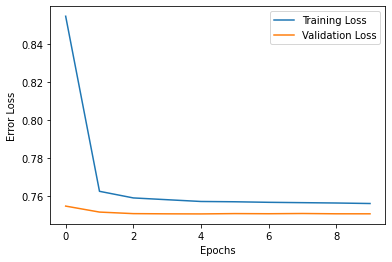

In [64]:
filtro = 32
kernel = 7


# model = keras.Sequential(
#     [
#         layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
#         layers.Conv1D(
#             filters=filtro, kernel_size=kernel, padding="same", strides=2, activation="relu"
#         ),
#         layers.Dropout(rate=0.2), 
#         layers.Conv1D(
#             filters=filtro/2, kernel_size=kernel, padding="same", strides=2, activation="relu"
#         ),
#         layers.Conv1DTranspose(
#             filters=filtro/2, kernel_size=kernel, padding="same", strides=2, activation="relu"
#         ),
#         layers.Dropout(rate=0.2),
#         layers.Conv1DTranspose(
#             filters=filtro, kernel_size=kernel, padding="same", strides=2, activation="relu"
#         ),
#         layers.Conv1DTranspose(filters=1, kernel_size=kernel, padding="same"),
#     ]
# )

## TFLM no tiene soporte para a capa Conv1D, por lo cual es necesario pasar a Conv2D agregando una dimensión mas:
## https://stackoverflow.com/questions/66664484/tensorflow-lite-on-arduino-nano-33-ble-didnt-find-op-for-builtin-opcode-expa

model = keras.Sequential(
        [
            layers.Input(shape=(x_train.shape[1], x_train.shape[2], 1)),
            layers.Conv2D(
                filters=filtro, kernel_size=(kernel, 1), padding="same", strides=2, activation="relu"
            ),
            layers.Dropout(rate=0.2),
            layers.Conv2D(
                filters=filtro/2, kernel_size=(kernel, 1), padding="same", strides=2, activation="relu"
            ),
            layers.Conv2DTranspose(
                filters=filtro/2, kernel_size=(kernel, 1), padding="same", strides=2, activation="relu"
            ),
            layers.Dropout(rate=0.2),
            layers.Conv2DTranspose(
                filters=filtro, kernel_size=(kernel, 1), padding="same", strides=2, activation="relu"
            ),
            layers.Conv2DTranspose(filters=1, kernel_size=(kernel, 1), padding="same"),
        ]
    )




model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss="mse")

model.summary()
#plot_model(model, to_file='model_plot_convo.png', show_shapes=True, show_layer_names=True)

history = model.fit(
    x_train,
    x_train,
    verbose=0,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    validation_data=(x_train,x_train),
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

fin = datetime.now()
#print("Tiempo RNN:", time_rnn.time())
#print("Tiempo de entrenamiento:",tiempo_entrenamiento)
print("Tiempo total:", fin-inicio)

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Error Loss')
plt.legend()
#plt.savefig("Auto_training.eps", dpi=200, bbox_inches='tight')
plt.show()

3159/3159 [==============================] - 4s 1ms/step


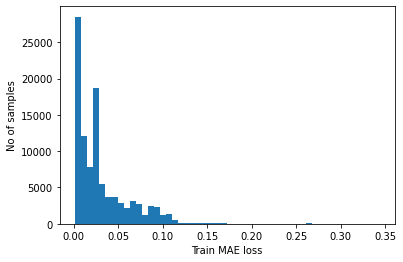

Reconstruction error threshold:  0.3434174419727025


In [65]:
x_train_pred = model.predict(x_train)
x_train_pred = np.sum(x_train_pred, axis=2) # Reshaping the array for compatibility with 1D model
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()


# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)


In [63]:
del model

In [4]:
datos

,codigoSerial,fecha,hora,temperatura,humedad_relativa,pm25,pm25_outlier
0,2,2020-02-01,00:00:00,22.67,71.69,40.1096,N
1,2,2020-02-01,00:01:00,22.64,71.79,38.6641,N
2,2,2020-02-01,00:02:00,22.61,71.87,31.4366,N
3,2,2020-02-01,00:03:00,22.60,71.97,37.2186,N
4,2,2020-02-01,00:04:00,22.58,72.12,38.6641,N
...,...,...,...,...,...,...,...
38532,2,2020-02-29,18:57:00,25.17,64.03,41.5551,N
38533,2,2020-02-29,18:58:00,25.15,64.21,199.9486,40.1096
38534,2,2020-02-29,18:59:00,25.14,64.35,43.0006,N
38535,2,2020-02-29,19:00:00,25.11,64.51,40.1096,N


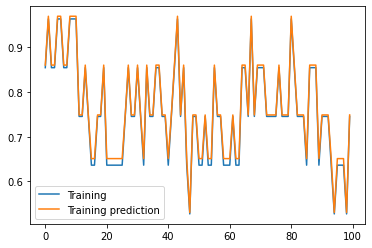

In [66]:
# Checking how the sequence is learnt

train = []
for i in range (len(x_train)):
    train.append(x_train[i][0][0])

train_pred = []
for i in range (len(x_train_pred)):
    train_pred.append(np.mean(x_train_pred[i]))

plt.plot(train[0:100], label="Training")
plt.plot(train_pred[0:100], label="Training prediction")
plt.legend()
#plt.savefig("Auto_prediction_training.eps", dpi=200, bbox_inches='tight')
plt.show()


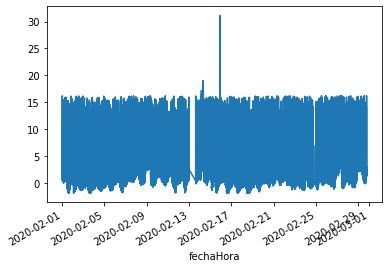

Test input shape:  (38537, 1, 1)
1205/1205 [==============================] - 2s 1ms/step


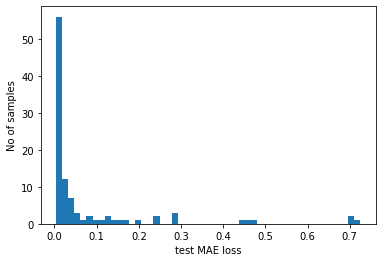

Number of anomaly samples:  2668
Indices of anomaly samples:  (array([    8,     9,    12, ..., 38453, 38504, 38533], dtype=int64),)


In [68]:
df_test_value = (df_daily_jumpsup - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
x_test_pred = np.sum(x_test_pred, axis=2) # Reshaping the array for compatibility with 1D model
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss[0:100], bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [69]:
lista_pred = []
for i in range (len(x_test_pred)):
    lista_pred.append(np.mean(x_test_pred[i]))
# print(lista_pred[300:310])

# lista_test = []
# for i in range (len(x_test)):
#     lista_test.append(x_test[i][0][0])
# print(lista_test[0:50])

lista_pred[0:10]

index = np.where(anomalies)
prediccion['detected'] = prediccion.loc[list(index[0]),'pm25']


In [70]:
#prediccion.assign(detected=) = pd.DataFrame(columns =["outlier"])
#pred['outlier'] = [0]*len(prediccion)
prediccion['detected'] = prediccion.loc[list(index[0]),'pm25']





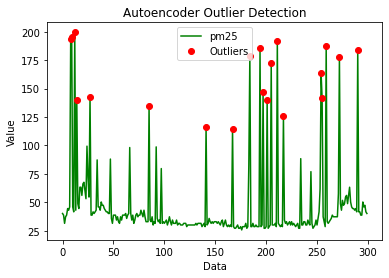

In [71]:
pred = prediccion[0:300]

#lista_pred = x_test_pred[2].reshape(100).tolist()# + x_test_pred[3].reshape(100).tolist()
#test_datos.append(x_test_pred[0].reshape(100).tolist())
#test_datos.append(x_test_pred[1].reshape(100).tolist())
#plt.plot(df_test_value.values[440:480], color='blue')
#plt.plot(prediccion.pm25.values[0:300], color='green', label="pm25")

plt.plot(pred.index, pred.pm25, color="green",label="pm25")
plt.plot(pred.index, pred.detected, 'o', color="red",label="Outliers")
plt.title('Autoencoder Outlier Detection')
plt.xlabel('Data')
plt.ylabel('Value')
#plt.plot(test_datos[0:1])
plt.legend(loc='upper center')
#plt.savefig("Auto_result.eps", dpi=200, bbox_inches='tight')
plt.show()

(0.9656434076342216,
 0.6743642968344578,
 0.9741379310344828,
 0.7969947868751918)

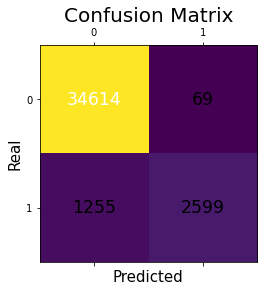

In [72]:
real = prediccion.pm25_outlier.tolist()
real = ['S' if value!='N' else value for value in real]
predicho = ['S' if value==True else value for value in anomalies]
predicho = ['N' if value==False else value for value in predicho]
confu_matrix (real[0:len(predicho)],predicho)

In [73]:
prediccion

,codigoSerial,fecha,hora,temperatura,humedad_relativa,pm25,pm25_dif,pm25_outlier,fechaHora,detected
0,2,2020-02-01,00:00:00,22.67,71.69,40.1096,0.0000,N,2020-02-01 00:00:00,NaN
1,2,2020-02-01,00:01:00,22.64,71.79,38.6641,1.4455,N,2020-02-01 00:01:00,NaN
2,2,2020-02-01,00:02:00,22.61,71.87,31.4366,7.2275,N,2020-02-01 00:02:00,NaN
3,2,2020-02-01,00:03:00,22.60,71.97,37.2186,5.7820,N,2020-02-01 00:03:00,NaN
4,2,2020-02-01,00:04:00,22.58,72.12,38.6641,1.4455,N,2020-02-01 00:04:00,NaN
...,...,...,...,...,...,...,...,...,...,...
38532,2,2020-02-29,18:57:00,25.17,64.03,41.5551,0.0000,N,2020-02-29 18:57:00,NaN
38533,2,2020-02-29,18:58:00,25.15,64.21,199.9486,158.3935,40.1096,2020-02-29 18:58:00,199.9486
38534,2,2020-02-29,18:59:00,25.14,64.35,43.0006,156.9480,N,2020-02-29 18:59:00,NaN
38535,2,2020-02-29,19:00:00,25.11,64.51,40.1096,2.8910,N,2020-02-29 19:00:00,NaN
